# Baseline-Point2Point Training

### Load Libraries

In [220]:
from util import *
from util.parser import *
from util.img_kit import *
from IPython import display
import numpy as np
from scipy import ndimage
from scipy import misc
from os import walk
import os
from PIL import Image
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (20.0, 20.0) # set default size of plots

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Set Gap

In [221]:
gap = 1  # size of gap to interpolate

assert gap%2==1, "gap must be an odd number, so that we can get the ground-truth mid-image!"
assert gap>0, "gap must be positive!"
assert gap < len(imgs), "gap must be smaller than length of total images"

### Load Image Data

In [260]:
base_index = parse_img_index(imgs[0])
to = parse_img_index(imgs[-1]) - (len(imgs)-1)%(gap + 1)
total_imgs = to - base_index + 1
num_intervals = (to-base_index)//(gap + 1)

print("Select Range:  {} -> {} | {} Intervals".format(base_index, to, num_intervals))

Select Range:  1 -> 15 | 7 Intervals


In [261]:
def index_to_img(i):
    return "{}/{}.{}".format(img_folder, "%03d"%(base_index + i), postfix)

In [263]:
x_index = [i*gap for i in range(num_intervals + 1)]
mid_index = [x + (gap+1)//2 for x in x_index[:-1]]

x_imgs = np.array([misc.imread(index_to_img(i)) for i in x_index]).astype('float32')    # training images
y_imgs = np.array([misc.imread(index_to_img(i)) for i in mid_index]).astype('float32')  # ground truth of images in betwen
print("x_imgs shape: {}".format(x_imgs.shape))
print("y_imgs shape: {}".format(y_imgs.shape))

x_imgs /= mean
y_imgs /= mean

x_imgs_all = np.array([misc.imread(index_to_img(i)) for i in range(total_imgs)]).astype('float32')    # training images
mean = np.mean(x_imgs_all, axis=0)

x_imgs -= mean
y_imgs -= mean

x_imgs shape: (8, 128, 128, 3)
y_imgs shape: (7, 128, 128, 3)


## Prepare Training Data

#### Set Batch Size

In [225]:
batch_size = 5
assert batch_size <=num_intervals, "batch_size must be <= num_intervals, which is {}".format(num_intervals)

In [226]:
def sample():
    """
    Select a batch size of data-point from X and y
    """
    start = np.random.choice(list(range(num_intervals)), size = batch_size, replace=False)
    start_x = x_imgs[start,...]
    end_x = x_imgs[start + 1,...]
    """  average to get batch_x  """
    batch_x = (start_x + end_x)/2
    batch_y = y_imgs[start,...]
    return (batch_x, batch_y)

### Display Input

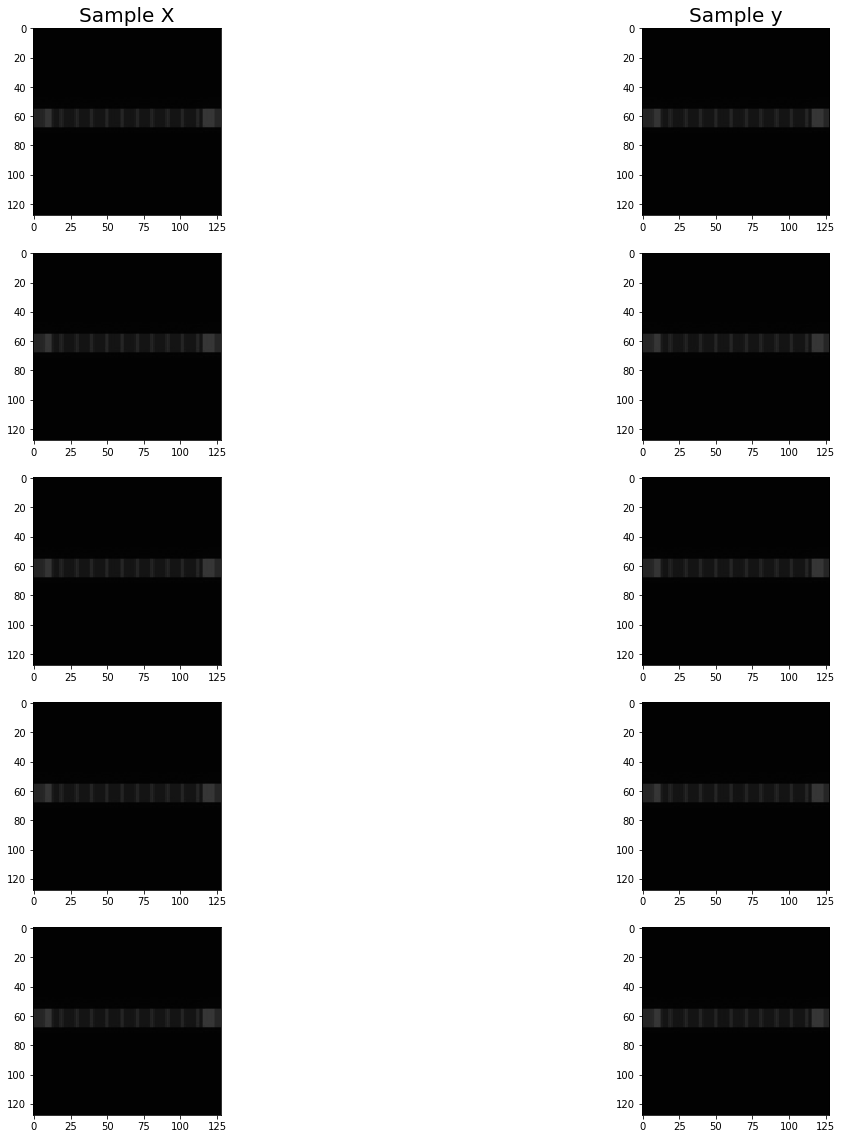

In [264]:
test_sample_x, test_sample_y = sample()
for i in range(batch_size):
    plt.subplot(batch_size, 2, i*2 + 1)
    if i == 0: plt.title("Sample X", fontsize=20)
    plt.imshow(test_sample_x[i].astype('uint8'))
    
    plt.subplot(batch_size, 2, i*2 + 2)
    if i == 0: plt.title("Sample y", fontsize=20)
    plt.imshow(test_sample_y[i].astype('uint8'))

## Train with Neural Network

In [284]:
num_filter = 32
def get_model(X):
    X = tf.layers.conv2d(inputs=X, filters=num_filter, kernel_size=[4, 4], strides = [1,1], padding="same", activation=None)
    X = tf.tanh(X)
    X = tf.layers.conv2d(inputs=X, filters=num_filter, kernel_size=[4, 4], strides = [1,1], padding="same", activation=None)
    X = tf.tanh(X)
#     X = tf.layers.conv2d(inputs=X, filters=num_filter, kernel_size=[4, 4], strides = [1,1], padding="same", activation=None)
#     X = tf.nn.relu(X)
    
    output = tf.layers.conv2d(inputs=X, filters=3, kernel_size=[4, 4], strides = [1,1], padding="same", activation=None)
    output = tf.tanh(output)
    return output

In [285]:
width, height = x_imgs.shape[1:3]
X = tf.placeholder(tf.float32, [None, width, height, 3])
y = tf.placeholder(tf.float32, [None, width, height, 3])
model = get_model(X)

#### Loss

In [286]:
# loss = tf.reduce_mean(tf.nn.l2_loss(model - y))
loss = tf.reduce_mean(tf.abs(model - y))

#### Optimizer

In [287]:
learning_rate = 1
optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(loss)

### Run Model

In [288]:
iters = 50
print_every = 10
loss_records = []
sess = sess =  tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(iters):
    sample_x, sample_y = sample()
    curr_loss, _ = sess.run([loss, train_step], {X: sample_x, y: sample_y})
    loss_records.append(curr_loss)
    if i%print_every == 0: print("Iteration {}: Loss = {:.3e}".format(i, curr_loss))

Iteration 0: Loss = 2.511e+02
Iteration 10: Loss = 2.525e+02
Iteration 20: Loss = 2.525e+02
Iteration 30: Loss = 2.525e+02
Iteration 40: Loss = 2.525e+02


#### plot loss

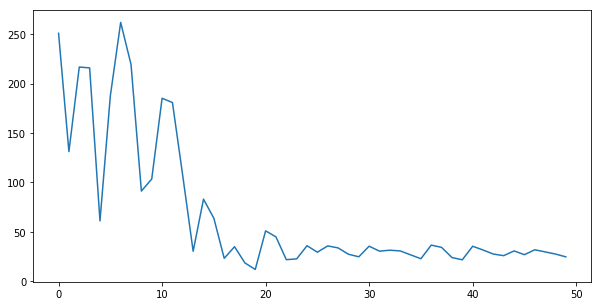

In [280]:
plt.figure(figsize=(10,5))
plt.plot(loss_records)
plt.show()

#### Display Training Result

In [281]:
sample_x, sample_y = sample()

train_output = sess.run(model, {X: sample_x, y: sample_y})

train_output = (train_output + mean) * 255

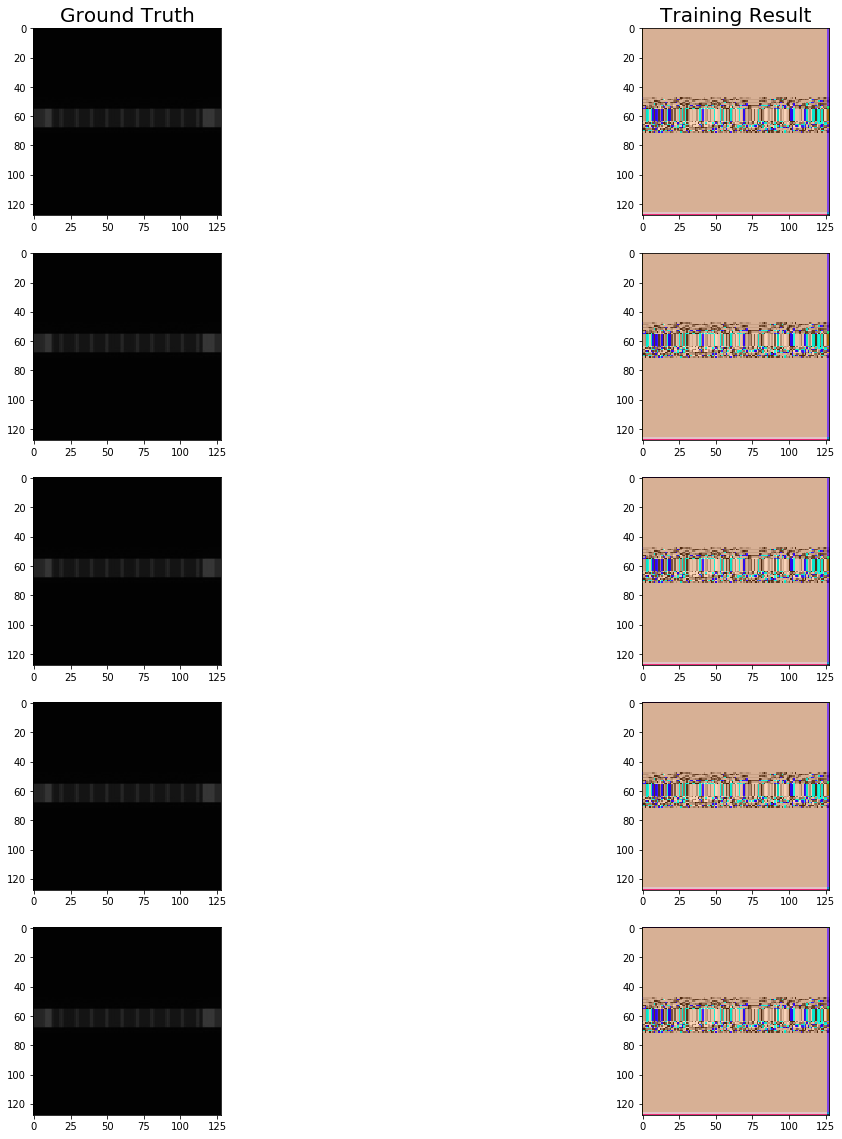

In [282]:
for i in range(batch_size):
    plt.subplot(batch_size, 2, i*2 + 1)
    if i == 0: plt.title("Ground Truth", fontsize=20)
    plt.imshow(sample_y[i].astype('uint8'))
    
    plt.subplot(batch_size, 2, i*2 + 2)
    if i == 0: plt.title("Training Result", fontsize=20)
#     train_output[i][train_output[i]<0] = 0
    plt.imshow(train_output[i].astype('uint8'))

In [283]:
assert (train_output[0]>=0).all()

AssertionError: 

In [ ]:
print(train_output[0]-sample_y[0])